# Image Registration

## Inspired by VoxelMorph. Uses a spatial transformer layer to align images.

In [1]:
import os
import errno

import numpy as np
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
        
import deepcell
import skimage

W1014 02:41:05.003234 140513269851968 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1624: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Load images

In [2]:
from skimage.filters import threshold_otsu, threshold_local
import fnmatch

base_direc = '/data/mibi/mibi_registration/chunks-corrected-2019-10-01'
direc_list = ['x04y02', 'x04y06', 'x06y05','x06y07']

hae_list = []
if_list = []


for direc in direc_list:
    full_direc = os.path.join(base_direc, direc)
    file_list = os.listdir(full_direc)
    
    for file in file_list:
        is_hae = fnmatch.fnmatch(file, '2019*HAE*.tif')
        is_if = fnmatch.fnmatch(file, '20190906*HighConc_Large_*.tif')
        
        if is_hae:
            hae_list.append(os.path.join(full_direc, file))       
        elif is_if:
            if_list.append(os.path.join(full_direc, file))

            
X_list = []
y_list = []

print(hae_list, if_list)

for h, i in zip(hae_list, if_list):
    X = deepcell.utils.io_utils.get_image(h)
    y = deepcell.utils.io_utils.get_image(i)[2]
    
    X = skimage.color.rgb2gray(X)
    X = 65535-X
    print(X.shape, y.shape)
    
    X = skimage.transform.resize(X, [128, 128])
    y = skimage.transform.resize(y, [128, 128])

    X_list.append(X)
    y_list.append(y)
    
X = np.stack(X_list, axis=0)
y = np.stack(y_list, axis=0)

X = np.expand_dims(X, axis=-1)
y = np.expand_dims(y, axis=-1)

train_data = {}
train_data['X'] = X
train_data['y'] = y

# file_name = '/data/hae_am.npz'
# np.savez(file_name, X=X, y=y)

# train_dict, test_dict = deepcell.utils.data_utils.get_data(file_name)

print(X.shape, y.shape)


['/data/mibi/mibi_registration/chunks-corrected-2019-10-01/x04y02/20190911_MIBI_HighConc_HAE_PFS_approxreg_x_04_y_02.tif', '/data/mibi/mibi_registration/chunks-corrected-2019-10-01/x04y06/20190911_MIBI_HighConc_HAE_PFS_approxreg_x_04_y_06.tif', '/data/mibi/mibi_registration/chunks-corrected-2019-10-01/x06y05/20190911_MIBI_HighConc_HAE_PFS_approxreg_x_06_y_05.tif', '/data/mibi/mibi_registration/chunks-corrected-2019-10-01/x06y07/20190911_MIBI_HighConc_HAE_PFS_approxreg_x_06_y_07.tif'] ['/data/mibi/mibi_registration/chunks-corrected-2019-10-01/x04y02/20190906_MIBI_HighConc_Large_approxreg_x_04_y_02.tif', '/data/mibi/mibi_registration/chunks-corrected-2019-10-01/x04y06/20190906_MIBI_HighConc_Large_approxreg_x_04_y_06.tif', '/data/mibi/mibi_registration/chunks-corrected-2019-10-01/x06y05/20190906_MIBI_HighConc_Large_approxreg_x_06_y_05.tif', '/data/mibi/mibi_registration/chunks-corrected-2019-10-01/x06y07/20190906_MIBI_HighConc_Large_approxreg_x_06_y_07.tif']
(2318, 2373) (2318, 2373)
(231

## Create registration generator

In [3]:
from tensorflow.python.keras.preprocessing.image import Iterator, ImageDataGenerator
from tensorflow.python.keras import backend as K

class RegistrationIterator(Iterator):
    """Iterator yielding data from Numpy arrayss (X and y).

    Args:
        train_dict: dictionary consisting of numpy arrays for X and y.
        image_data_generator: Instance of ImageDataGenerator
            to use for random transformations and normalization.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of 'channels_first', 'channels_last'.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if save_to_dir is set).
        save_format: Format to use for saving sample images
            (if save_to_dir is set).
    """

    def __init__(self,
                 train_dict,
                 image_data_generator,
                 batch_size=1,
                 shuffle=False,
                 transform=None,
                 transform_kwargs={},
                 seed=None,
                 data_format='channels_last',
                 save_to_dir=None,
                 save_prefix='',
                 save_format='png'):
        X, y = train_dict['X'], train_dict['y']
        if X.shape[0] != y.shape[0]:
            raise ValueError('Training batches and labels should have the same'
                             'length. Found X.shape: {} y.shape: {}'.format(
                                 X.shape, y.shape))
        self.x = np.asarray(X, dtype=K.floatx())
        self.y = np.asarray(y, dtype=K.floatx())

        if self.x.ndim != 4:
            raise ValueError('Input data in `ImageFullyConvIterator` '
                             'should have rank 4. You passed an array '
                             'with shape', self.x.shape)

        self.channel_axis = 3 if data_format == 'channels_last' else 1
        self.image_data_generator = image_data_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(RegistrationIterator, self).__init__(
            self.x.shape[0], batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros(tuple([len(index_array)] + list(self.x.shape)[1:]))
        batch_y = np.zeros(tuple([len(index_array)] + list(self.y.shape)[1:]))
        batch_t = np.zeros(tuple([len(index_array)] + [2]))
        for i, j in enumerate(index_array):
            x = self.x[j]

            if self.y is not None:
                y = self.y[j]
                params = self.image_data_generator.get_random_transform(x.shape, self.seed)
                x = self.image_data_generator.apply_transform(x.astype(K.floatx()), params)
                y = self.image_data_generator.apply_transform(y.astype(K.floatx()), params)
    
                tx = params['tx']/self.x.shape[1]
                ty = params['ty']/self.x.shape[2]
            
                t = np.array([tx, ty])

            x = self.image_data_generator.standardize(x)
            y = self.image_data_generator.standardize(y)

            batch_x[i] = x
            batch_y[i] = y
            
        if self.save_to_dir:
            for i, j in enumerate(index_array):
                if self.data_format == 'channels_first':
                    img_x = np.expand_dims(batch_x[i, 0, ...], 0)
                else:
                    img_x = np.expand_dims(batch_x[i, ..., 0], -1)
                img = array_to_img(img_x, self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(
                    prefix=self.save_prefix,
                    index=j,
                    hash=np.random.randint(1e4),
                    format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))

                if self.y is not None:
                    # Save argmax of y batch
                    img_y = batch_y[i]
                    img_y = np.expand_dims(img_y, axis=self.channel_axis - 1)
                    img = array_to_img(img_y, self.data_format, scale=True)
                    fname = 'y_{prefix}_{index}_{hash}.{format}'.format(
                        prefix=self.save_prefix,
                        index=j,
                        hash=np.random.randint(1e4),
                        format=self.save_format)
                    img.save(os.path.join(self.save_to_dir, fname))

        if self.y is None:
            return batch_x

        return [batch_x, batch_y], [batch_x, batch_x]

    def next(self):
        """For python 2.x. Returns the next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)
    
class RegistrationGenerator(ImageDataGenerator):
    def flow(self,
             train_dict,
             batch_size=1,
             skip=None,
             transform=None,
             transform_kwargs={},
             shuffle=True,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png'):
   
        return RegistrationIterator(
            train_dict,
            self,
            batch_size=batch_size,
            transform=transform,
            transform_kwargs=transform_kwargs,
            shuffle=shuffle,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format)


In [4]:
datagen = RegistrationGenerator(rotation_range=45,
                                zoom_range=[0.8,1.2],
                                horizontal_flip=True, 
                                vertical_flip=True,
                                samplewise_center=True,
                                samplewise_std_normalization=True
                               )
datagen_val = RegistrationGenerator(samplewise_center=True,
                                samplewise_std_normalization=True)

train_gen = datagen.flow(train_data)
val_gen = datagen_val.flow(train_data)

In [5]:
(x_batch, y_batch), theta_batch = train_gen.next()
print(x_batch[0].shape)
print(y_batch[0].shape)

(128, 128, 1)
(128, 128, 1)


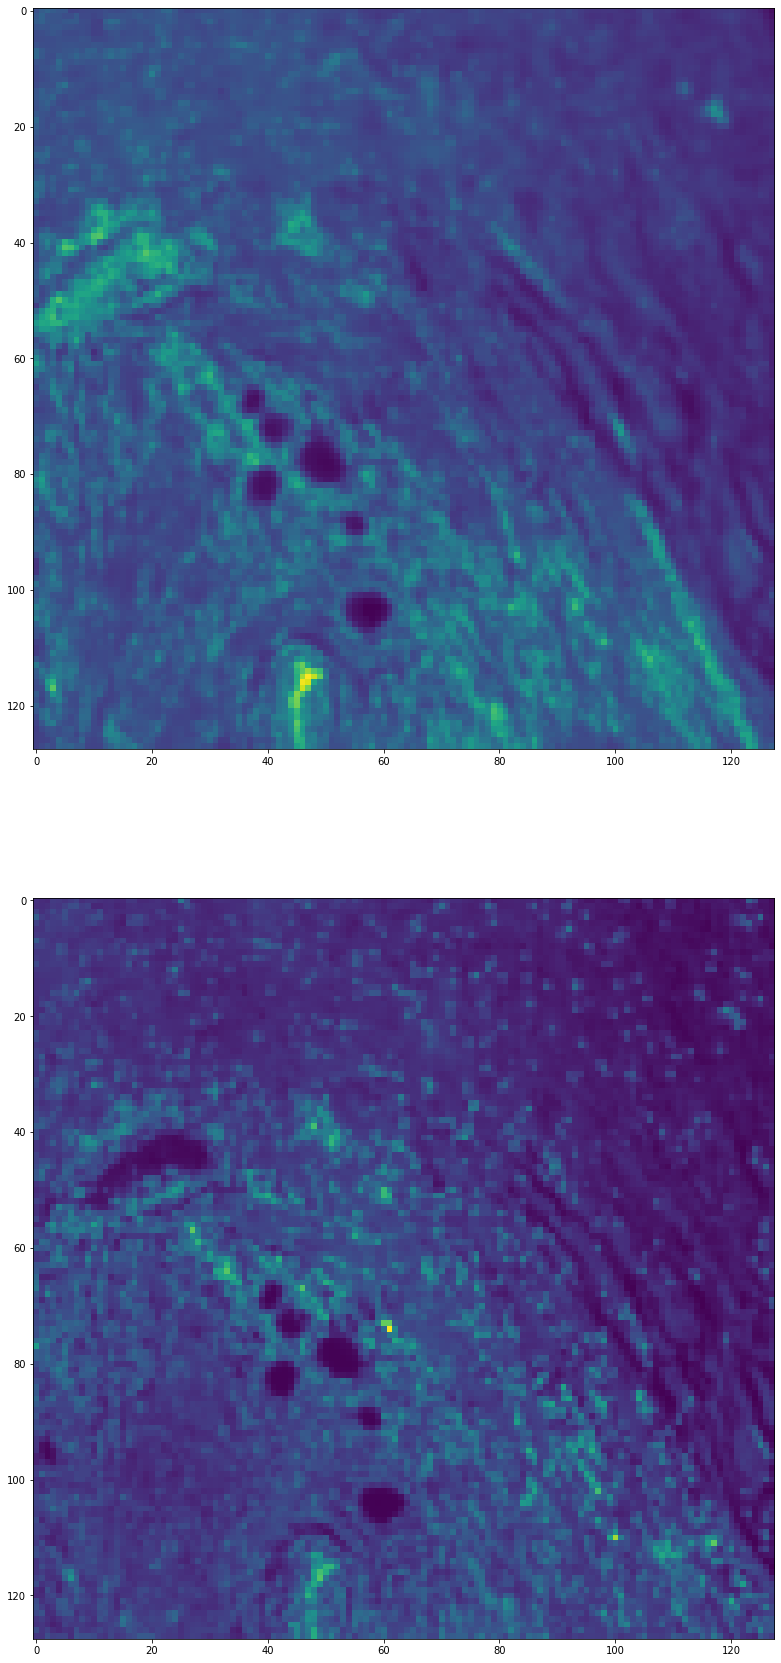

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,1, figsize=(30,30))
axes[0].imshow(X[2,...,0])
axes[1].imshow(y[2,...,0])


## Spatial Transformer Layer

In [7]:
from tensorflow.python.keras.layers import Layer
import itertools

class SpatialTransformer(Layer):
    """
    Spatial Transformer Layer
    addapted from 

      Unsupervised Learning for Fast Probabilistic Diffeomorphic Registration
      Adrian V. Dalca, Guha Balakrishnan, John Guttag, Mert R. Sabuncu
      MICCAI 2018.
    """

    def __init__(self,
                 single_transform=False,
                 affine=False,
                 interpolation_mode='linear',
                 **kwargs):
        """
        Parameters: 
            single_transform: Whether a single transform is used for the whole batch
            interpolation_mode: Whether to use nearest neighbor or linear interpolation
        """

        if interpolation_mode not in ['linear']:
            raise ValueError('interpolation_mode should be linear')

        self.interpolation_mode = interpolation_mode
        self.single_transform = single_transform
        self.affine = affine

        super(SpatialTransformer, self).__init__(**kwargs)

    def build(self, input_shape):
        """
        input_shape should be a list for two inputs:
        input1: image.
        input2: transform Tensor of shape *image_shape X ndim
        """

        if len(input_shape) > 2:
            raise Exception('Spatial Transformer must be called on a list of length 2.'
                            'First argument is the image, second is the transform.')
        
        self.in_shape = input_shape
        self.ndims = len(input_shape[0]) - 2 # Need to account for batch and channel dimensions

        # confirm built
        self.built = True

    def call(self, inputs):
        """
        Parameters
            inputs: list with two entries
        """
        # check shapes
        assert len(inputs) == 2, "inputs has to be len 2, found: %d" % len(inputs)
        image = inputs[0]
        transform = inputs[1]

        # necessary for multi_gpu models...
        image = K.reshape(image, [-1, *self.in_shape[0][1:]])
        transform = K.reshape(transform, [-1, *self.in_shape[1][1:]])

        if self.affine:
            transform = tf.map_fn(lambda x: self._affine_to_shift(x, image.shape[1:-1]), transform, dtype=K.floatx())
        
        # map transform across batch
        if self.single_transform:
            fn = lambda x: self._single_transform([x, transform[0,:]])
            return tf.map_fn(fn, image, dtype=tf.float32)
        else:
            return tf.map_fn(self._single_transform, [image, transform], dtype=tf.float32)
        
    def _affine_to_shift(self, affine_matrix, image_shape, shift_center=True):

        if isinstance(image_shape, (tf.Dimension, tf.TensorShape)):
            image_shape = image_shape.as_list()
        
        if len(affine_matrix.shape) == 1:  # go from vector to matrix
            affine_matrix = tf.reshape(affine_matrix, [self.ndims, self.ndims + 1])

        affine_matrix = tf.cast(affine_matrix, K.floatx())
        affine_matrix += tf.eye(self.ndims + 1)[:self.ndims, :] # add identity

        if len(affine_matrix.shape) == 1:
            if len(affine_matrix) != (self.ndims * (self.ndims + 1)):
                raise ValueError('')
            affine_matrix = tf.reshape(affine_matrix, [self.ndims, self.ndims + 1])

        if not (affine_matrix.shape[0] in [self.ndims, self.ndims + 1]):
            raise Exception('')

        linvec = [tf.range(0, d) for d in image_shape]
        mesh = tf.meshgrid(*linvec, indexing='ij')
        mesh = [tf.cast(f, K.floatx()) for f in mesh]
        
        if shift_center:
            mesh = [mesh[d] - (image_shape[d]-1)/2 for d in range(self.ndims)]

        flat_mesh = [self._flatten(f) for f in mesh]
        flat_mesh.append(tf.ones(flat_mesh[0].shape, dtype=K.floatx()))

        mesh_matrix = tf.transpose(tf.stack(flat_mesh, axis=1))

        location_matrix = tf.matmul(affine_matrix, mesh_matrix)
        location_matrix = tf.transpose(location_matrix[:self.ndims, :])
                            
        location = tf.reshape(location_matrix, list(image_shape) + [self.ndims])
        
        return location - tf.stack(mesh, axis=self.ndims)

    def _single_transform(self, inputs):
        image = inputs[0]
        loc_shift = inputs[1]
        return self._transform(image, loc_shift)
    
    def _transform(self, image, loc_shift):        
        image_shape = image.get_shape().as_list()[:-1]
        n_channels = image.get_shape()[-1]

        linvec = [tf.range(0, d) for d in image_shape]
        mesh = tf.meshgrid(*linvec, indexing='ij')
        
        loc = [tf.cast(mesh[d], K.floatx()) + loc_shift[..., d] for d in range(self.ndims)]
        loc = tf.stack(loc, axis=-1) 

        # Perform interpolation 
        if self.interpolation_mode == 'linear':
            # We need to grab the points in the neighborhood
            # around the shifted point

            # Round and clip
            loc0 = tf.floor(loc)
            max_loc = [d-1 for d in image_shape]
            clipped_loc = self._clip_values(loc, max_loc)
            clipped_loc0 = self._clip_values(loc0, max_loc)
            clipped_loc1 = self._clip_values(loc0 + 1, max_loc)

            locs = [[tf.cast(f, 'int32') for f in clipped_loc0], 
                        [tf.cast(f, 'int32') for f in clipped_loc1]]

            # Compute the difference between upper value and 
            # original value
            diff_loc1 = [clipped_loc1[d] - clipped_loc[d] for d in range(self.ndims)]
            diff_loc0 = [1 - d for d in diff_loc1]
            
            weights = [diff_loc1, diff_loc0]

            # Go through all neighborhood corners
            neighborhood_points = list(itertools.product([0, 1], repeat=self.ndims))
            interpolated_image = 0

            for point in neighborhood_points:
                subs = [locs[point[d]][d] for d in range(self.ndims)]
                idx = self._convert_to_flat_index(image_shape, subs)
                image_val = tf.gather(tf.reshape(image, [-1, n_channels]), idx)

                weights_list = [weights[point[d]][d] for d in range(self.ndims)]

                new_weights = self._prod_n(weights_list)
                new_weights = K.expand_dims(new_weights, -1)

                interpolated_image += new_weights * image_val

        return interpolated_image

    def _prod_n(self, lst):
        prod = lst[0]
        for p in lst[1:]:
            prod *= p
        return prod
    
    def _flatten(self, v):
        return tf.reshape(v, [-1])

    def _clip_values(self, loc, max_loc):
        clipped_loc = [tf.clip_by_value(loc[..., d], 0, max_loc[d]) for d in range(self.ndims)]
        return clipped_loc

    def _convert_to_flat_index(self, image_shape, location):
        assert len(image_shape) == len(location), 'inconsistent image_shape and location size'

        cum_shape = np.cumprod(image_shape[::-1])
        ndx = location[-1]

        for i, loc in enumerate(location[:-1][::-1]):
            ndx = ndx + loc * cum_shape[i]

        return ndx

    def compute_output_shape(self, input_shape):
        return tensor_shape.TensorShape(input_shape[-1])

    def get_config(self):
        config = {
            'single_transform': self.single_transform,
            'in_shape': self.in_shape
            }
        base_config = super(SpatialTransformer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Define model

In [8]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import numpy as np

import tensorflow.python.keras.layers as KL
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Conv2D, Conv3D, LSTM
from tensorflow.python.keras.layers import Input, Concatenate, InputLayer
from tensorflow.python.keras.layers import Flatten, Dense, Reshape
from tensorflow.python.keras.layers import MaxPool2D, MaxPool3D
from tensorflow.python.keras.layers import Cropping2D, Cropping3D
from tensorflow.python.keras.layers import Activation, Softmax
from tensorflow.python.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.python.keras.layers import ZeroPadding2D, ZeroPadding3D
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras import utils as keras_utils

from deepcell.layers import DilatedMaxPool2D, DilatedMaxPool3D
from deepcell.layers import ImageNormalization2D, ImageNormalization3D
from deepcell.layers import Location2D, Location3D
from deepcell.layers import ReflectionPadding2D, ReflectionPadding3D
from deepcell.layers import TensorProduct

def conv_block(x_in, nf, strides=1):
    """
    specific convolution module including convolution followed by leakyrelu
    """
    ndims = len(x_in.get_shape()) - 2
    assert ndims in [1, 2, 3], "ndims should be one of 1, 2, or 3. found: %d" % ndims

    Conv = getattr(KL, 'Conv%dD' % ndims)
    x_out = Conv(nf, kernel_size=3, padding='same',
                 kernel_initializer='he_normal', strides=strides)(x_in)
    x_out = LeakyReLU(0.2)(x_out)
    return x_out

def unet_core(vol_size, enc_nf, dec_nf, full_size=True, src=None, tgt=None, src_feats=1, tgt_feats=1):
    """
    unet architecture for voxelmorph models presented in the CVPR 2018 paper. 
    You may need to modify this code (e.g., number of layers) to suit your project needs.
    :param vol_size: volume size. e.g. (256, 256, 256)
    :param enc_nf: list of encoder filters. right now it needs to be 1x4.
           e.g. [16,32,32,32]
    :param dec_nf: list of decoder filters. right now it must be 1x6 (like voxelmorph-1) or 1x7 (voxelmorph-2)
    :return: the keras model
    """
    ndims = len(vol_size)
    assert ndims in [1, 2, 3], "ndims should be one of 1, 2, or 3. found: %d" % ndims
    upsample_layer = getattr(KL, 'UpSampling%dD' % ndims)

    # inputs
    if src is None:
        src = Input(shape=[*vol_size, src_feats])
    if tgt is None:
        tgt = Input(shape=[*vol_size, tgt_feats])
    x_in = Concatenate(axis=-1)([src, tgt])
    

    # down-sample path (encoder)
    x_enc = [x_in]
    for i in range(len(enc_nf)):
        x_enc.append(conv_block(x_enc[-1], enc_nf[i], 2))

    # up-sample path (decoder)
    x = conv_block(x_enc[-1], dec_nf[0])
    x = upsample_layer()(x)
    x = Concatenate(axis=-1)([x, x_enc[-2]])
    x = conv_block(x, dec_nf[1])
    x = upsample_layer()(x)
    x = Concatenate(axis=-1)([x, x_enc[-3]])
    x = conv_block(x, dec_nf[2])
    x = upsample_layer()(x)
    x = Concatenate(axis=-1)([x, x_enc[-4]])
    x = conv_block(x, dec_nf[3])
    x = conv_block(x, dec_nf[4])
    
    # only upsampleto full dim if full_size
    # here we explore architectures where we essentially work with flow fields 
    # that are 1/2 size 
    if full_size:
        x = upsample_layer()(x)
        x = Concatenate(axis=-1)([x, x_enc[0]])
        x = conv_block(x, dec_nf[5])

    # optional convolution at output resolution (used in voxelmorph-2)
    if len(dec_nf) == 7:
        x = conv_block(x, dec_nf[6])

    return Model(inputs=[src, tgt], outputs=[x])
    
def VMModel(image_shape=(128, 128)):
    unet_model = unet_core(image_shape, [16, 32, 32, 32], [16, 32, 32, 32, 32, 32])
    [input_1, input_2] = unet_model.inputs
    x = unet_model.output
    flow = Conv2D(2, 
                kernel_size=3, 
                padding='same', 
                kernel_initializer=RandomNormal(mean=0.0, stddev=1e-5),
                name='flow')(x)
    spatial_transformer = SpatialTransformer(interpolation_mode='linear', name='spatial_transformer')([input_2, flow])
    model = Model(inputs=[input_1, input_2], outputs=[spatial_transformer, flow])
    return model




In [20]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.initializers import RandomNormal
from tensorflow.python.keras.layers import Input, Conv2D, Conv3D, BatchNormalization, AveragePooling2D
from tensorflow.python.keras.layers import Activation, MaxPool2D, MaxPool3D, Concatenate
from tensorflow.python.keras.layers import Dense, Flatten, TimeDistributed, Lambda, Softmax
from deepcell.model_zoo import bn_feature_net_2D
from deepcell.layers import ImageNormalization2D, TensorProduct
from deepcell.utils.backbone_utils import get_backbone

def dense_block(input_tensor):
    dense_1 = TensorProduct(128)(input_tensor)
    bn_1 = BatchNormalization(axis=-1)(dense_1)
    act_1 = Activation('relu')(bn_1)
    
    return act_1


def AlignmentModel(input_shape_1=(128,128,1),
                   input_shape_2=(128,128,1),
                   norm_method='whole_image'):
    
    if K.image_data_format() == 'channels_first':
        channel_axis = 0
    else:
        channel_axis = -1
        
    input_1 = Input(shape=input_shape_1)
    input_2 = Input(shape=input_shape_2)
    
    inputs = Concatenate(axis=-1)([input_1, input_2])
    
    fn_model = bn_feature_net_2D(receptive_field=31,
                                input_shape = (128, 128, 2),
                                 n_conv_filters=32,
                                 n_dense_filters=128,
                                include_top=False,
                                dilated=True,
                                norm_method=norm_method
                                )
    
    fn_output = fn_model(inputs)
    dense_1 = dense_block(fn_output)
    flow = Conv2D(2, 
                  kernel_size= 3, 
                  padding='SAME',
                  name='flow',
                  kernel_initializer=RandomNormal(mean=0.0, stddev=1e-5))(dense_1)
    
    spatial_transformer = SpatialTransformer(interpolation_mode='linear', name='spatial_transformer')([input_2, flow])
    
    return Model(inputs=[input_1, input_2], outputs=[spatial_transformer, flow])
    
    

In [21]:
alignment_model = AlignmentModel(norm_method=None)

In [22]:
alignment_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 128, 128, 2)  0           input_12[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
model_6 (Model)                 (None, 128, 128, 128 104578      concatenate_8[0][0]        

## Define losses and compile model

In [23]:
class VoxelMorphLosses(object):
    def __init__(self,
                 win=None, 
                 eps=1e-5,
                 penalty='l1',
                 grad_weight=1):
        # Set window size
        if win is None:
            win = [31]
        else:
            win = [win]
        self.win = win
        self.eps = eps
        
        if penalty not in ['l1', 'l2']:
            raise ValueError('penalty can only be l1 or l2')
        else:
            self.penalty = penalty   
            
        self.grad_weight=grad_weight
            
    def ncc_loss(self):
        def _ncc(I, J):
            ndims = len(I.get_shape().as_list()) - 2
            win_list = self.win * ndims

            # Assert the dimensions are either 1, 2, or 3.
            assert ndims in [1, 2, 3], 'image dimension should be either 1, 2, or 3'

            # Get convolution function
            conv_fn = getattr(tf.nn, 'conv%dd' % ndims)

            # Compute cross correlations
            I2 = I*I
            J2 = J*J
            IJ = I*J

            # Compute local sums with convolution
            options = {
                'filters': tf.ones([*win_list, 1, 1]),
                'strides': 1,
                'padding': 'SAME'
            }

            I_sum = conv_fn(I, **options)
            J_sum = conv_fn(J, **options)
            I2_sum = conv_fn(I2, **options)
            J2_sum = conv_fn(J2, **options)
            IJ_sum = conv_fn(IJ, **options)

            # Compute cross correlation
            win_size = np.prod(self.win)
            u_I = I_sum / win_size
            u_J = J_sum / win_size

            cross = IJ_sum - u_J*I_sum - u_I*J_sum + u_I*u_J*win_size
            I_var = I2_sum - 2*u_I*I_sum + u_I*u_I*win_size
            J_var = J2_sum - 2*u_J*J_sum + u_J*u_J*win_size

            cross_correlation = cross*cross / (I_var*J_var + self.eps)
            cross_correlation = tf.reduce_mean(cross_correlation)

            return -cross_correlation

        return _ncc

    def gradient_loss(self):
        def _grad(y):
            y_shape = y.get_shape().as_list()[1:-1]
            ndims = len(y_shape)

            df = [None] * ndims
            for i in range(ndims):
                d = i + 1

                # Permute dimensions to put the ith dimension first
                r = [d, *range(d), *range(d+1, ndims+2)]
                y = K.permute_dimensions(y, r)
                dfi = y[1:, ...] - y[:-1, ...]

                # Permute back
                r = [*range(1, d+1), 0, *range(d+1, ndims+2)]
                df[i] = K.permute_dimensions(dfi, r)

            return df

        def _loss(y_true, y_pred):
            if self.penalty == 'l1':
                df = [tf.reduce_mean(tf.abs(f)) for f in _grad(y_pred)]
            else:
                df = [tf.reduce_mean(f*f) for f in _grad(y_pred)]
            return self.grad_weight*tf.add_n(df) / len(df)

        return _loss


In [24]:
from deepcell.utils.train_utils import rate_scheduler
from tensorflow.python.keras.optimizers import Adam, SGD
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.losses import MSE

n_epoch = 10
lr = 1e-5
optimizer = Adam(lr=lr, clipnorm=0.001)
# optimizer = SGD(lr=0.01)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

model_path='/data/models/align.h5'
batch_size=1
VML = VoxelMorphLosses(win=21, grad_weight=1)

# loss = MSE
# loss =  VoxelMorphLosses(win=31).normalized_cross_correlation_loss()
loss = {'spatial_transformer': MSE,
        'flow': VML.gradient_loss()}
       

alignment_model.compile(loss=loss, optimizer=optimizer)


In [31]:
alignment_model.fit_generator(
        train_gen,
        steps_per_epoch=5000,
        epochs=n_epoch,
        validation_data=train_gen,
        validation_steps=1000,
        callbacks=[
            callbacks.LearningRateScheduler(lr_sched),
            callbacks.ModelCheckpoint(
                model_path, monitor='val_loss', verbose=1,
                save_best_only=True, save_weights_only=False)])

Epoch 1/10
4999/5000 [============================>.] - ETA: 0s - loss: 0.9040 - spatial_transformer_loss: 0.7941 - flow_loss: 0.1048
Epoch 00001: val_loss improved from inf to 0.86822, saving model to /data/models/align.h5
5000/5000 [==============================] - 224s 45ms/step - loss: 0.9040 - spatial_transformer_loss: 0.7941 - flow_loss: 0.1048 - val_loss: 0.8682 - val_spatial_transformer_loss: 0.7492 - val_flow_loss: 0.1140
Epoch 2/10
3231/5000 [==================>...........] - ETA: 1:15 - loss: 0.8735 - spatial_transformer_loss: 0.7498 - flow_loss: 0.1187

KeyboardInterrupt: 

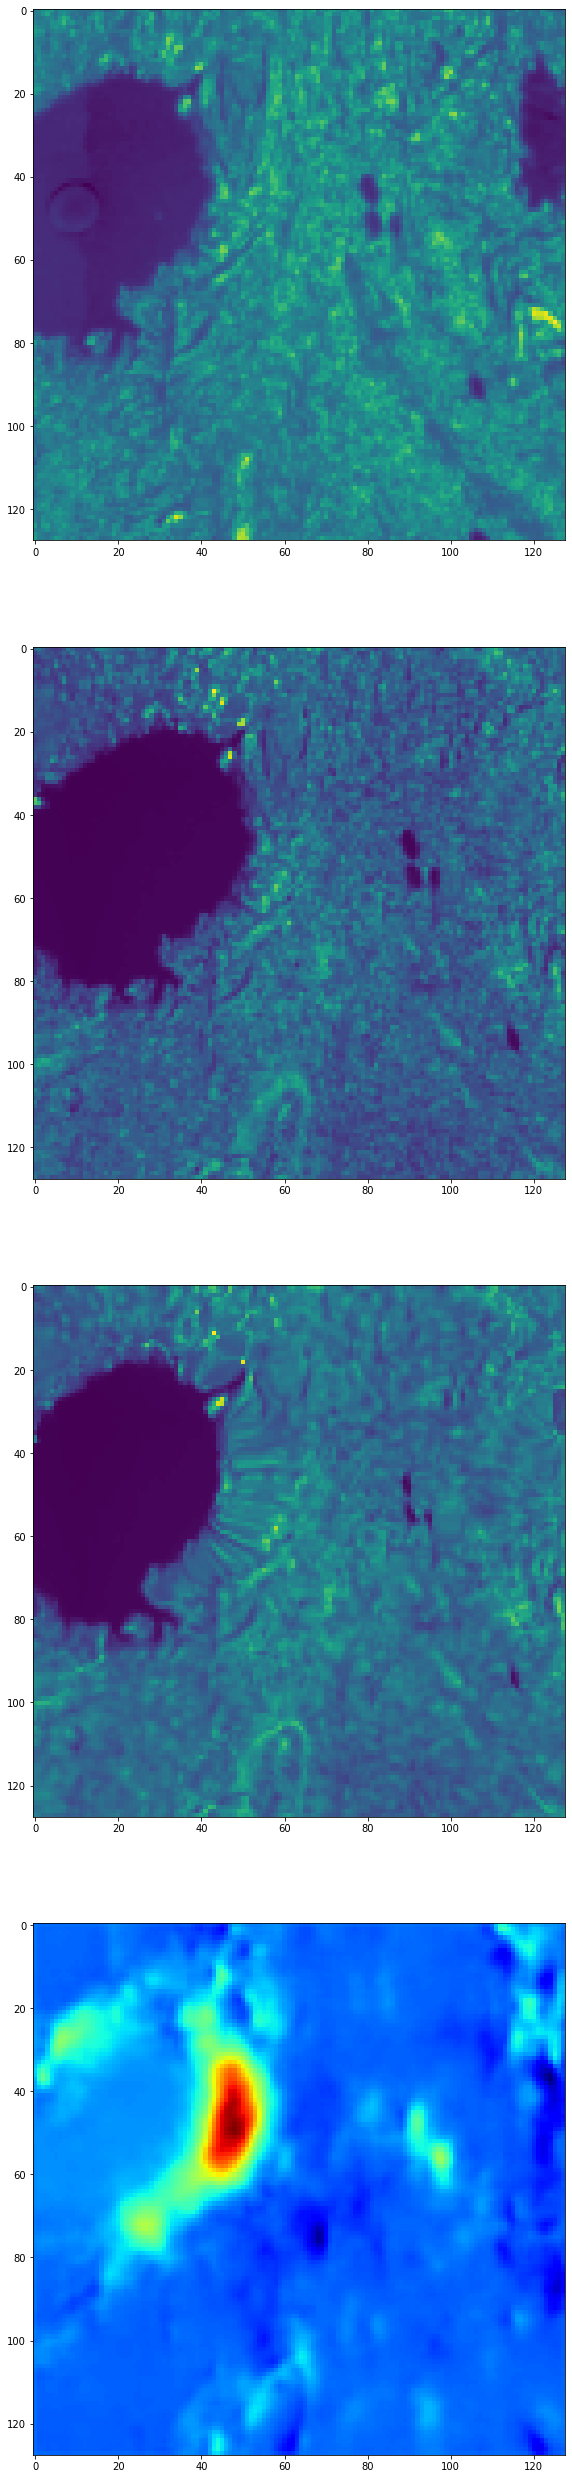

In [37]:
imgs, template = val_gen.next()
out = alignment_model.predict(imgs)

# print(template, np.array(out[1:]))
fig, axes = plt.subplots(4,1,figsize=(45,45))
axes[0].imshow(imgs[0][0,...,0])
axes[1].imshow(imgs[1][0,...,0])
axes[2].imshow(out[0][0,...,0])
axes[3].imshow(out[1][0,...,1], cmap='jet')

In [39]:
print(np.amax(out[1]))

9.978642
